## Load metadata

In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

We will create a matrix X which contains a row of PANAS scores for each scan. Then, we will perform PCA via singular value decomposition and use the right singular vectors in V to determine which PANAS scores contribute to which of the principal components. The goal is to see if any of the components capture many fatigue/alertness related scores, so that we can use those to calculate an alertness index.

See Principal Component Analysis in Methods of [1]


[1] Betzel, R. F., Satterthwaite, T. D., Gold, J. I., & Bassett, D. S. (2017). Positive affect, surprise, and fatigue are correlates of network flexibility. Scientific Reports, 7(1), 1–10. https://doi.org/10.1038/s41598-017-00425-z

## Get PANAS vectors for each scan

The PANAS categories...

In [12]:
df.columns[29:92]

Index(['panas:active', 'panas:afraid', 'panas:alert', 'panas:alone',
       'panas:amazed', 'panas:angry', 'panas:angry_at_self', 'panas:ashamed',
       'panas:astonished', 'panas:at_ease', 'panas:attentive', 'panas:bashful',
       'panas:blameworthy', 'panas:blue', 'panas:bold', 'panas:calm',
       'panas:cheerful', 'panas:concentrating', 'panas:confident',
       'panas:daring', 'panas:delighted', 'panas:determined',
       'panas:disgusted', 'panas:disgusted_with_self',
       'panas:dissatisfied_with_self', 'panas:distressed', 'panas:downhearted',
       'panas:drowsy', 'panas:energetic', 'panas:enthusiastic',
       'panas:excited', 'panas:fatigue', 'panas:fearless', 'panas:frightened',
       'panas:guilty', 'panas:happy', 'panas:hostile', 'panas:inspired',
       'panas:interested', 'panas:irritable', 'panas:jittery', 'panas:joyful',
       'panas:lively', 'panas:loathing', 'panas:lonely', 'panas:negative',
       'panas:nervous', 'panas:positive', 'panas:proud', 'panas:relax

Create the matrix X

<IPython.core.display.Javascript object>


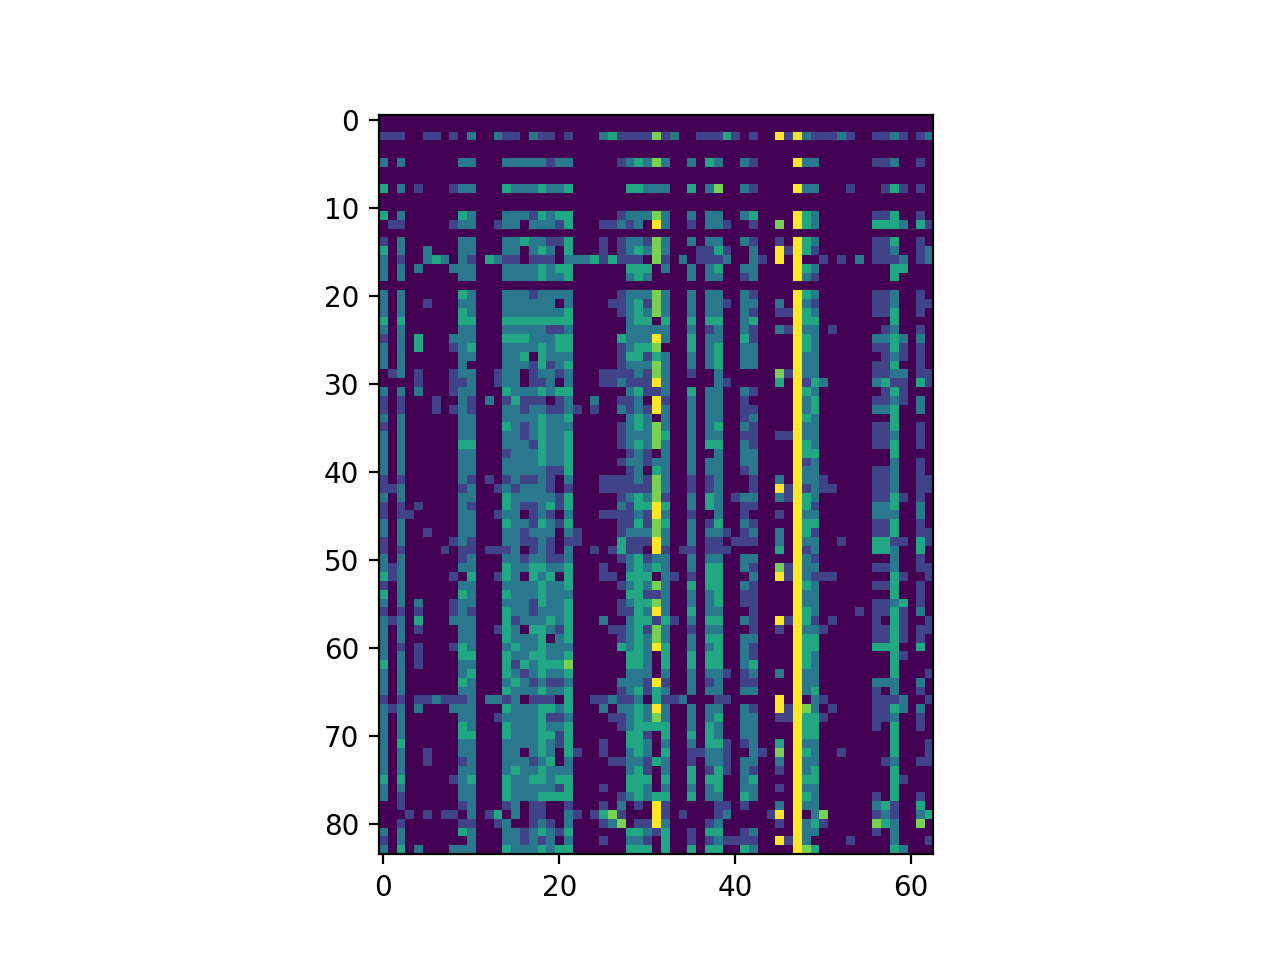

In [20]:
X = np.array(df.iloc[:,29:92])
X[X == '.'] = '0'
X = X.astype(int)

plt.close('all')
plt.imshow(X,vmin=0,vmax=5)
plt.show()

Remove scan sessions with all zero PANAS scores, or PANAS categories with all zeros .

<IPython.core.display.Javascript object>


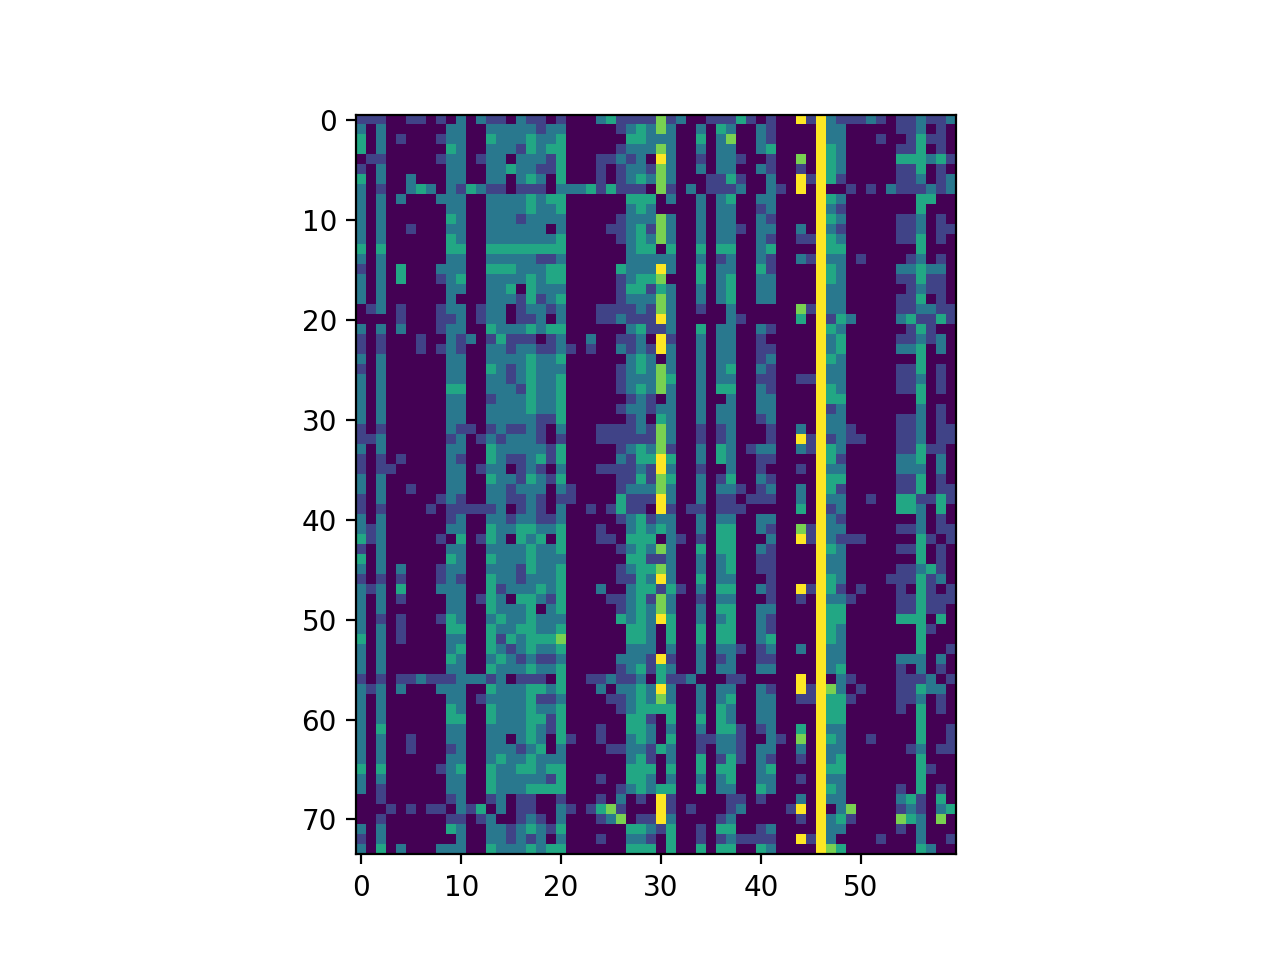

In [41]:
X1 = np.array([scan for scan in X if np.any(scan)])
X2 = np.array([cat for cat in X1.T if np.any(cat)]).T

plt.close('all')
plt.imshow(X2,vmin=0,vmax=5)
plt.show()

Z-score each PANAS category

(74, 60)


<IPython.core.display.Javascript object>


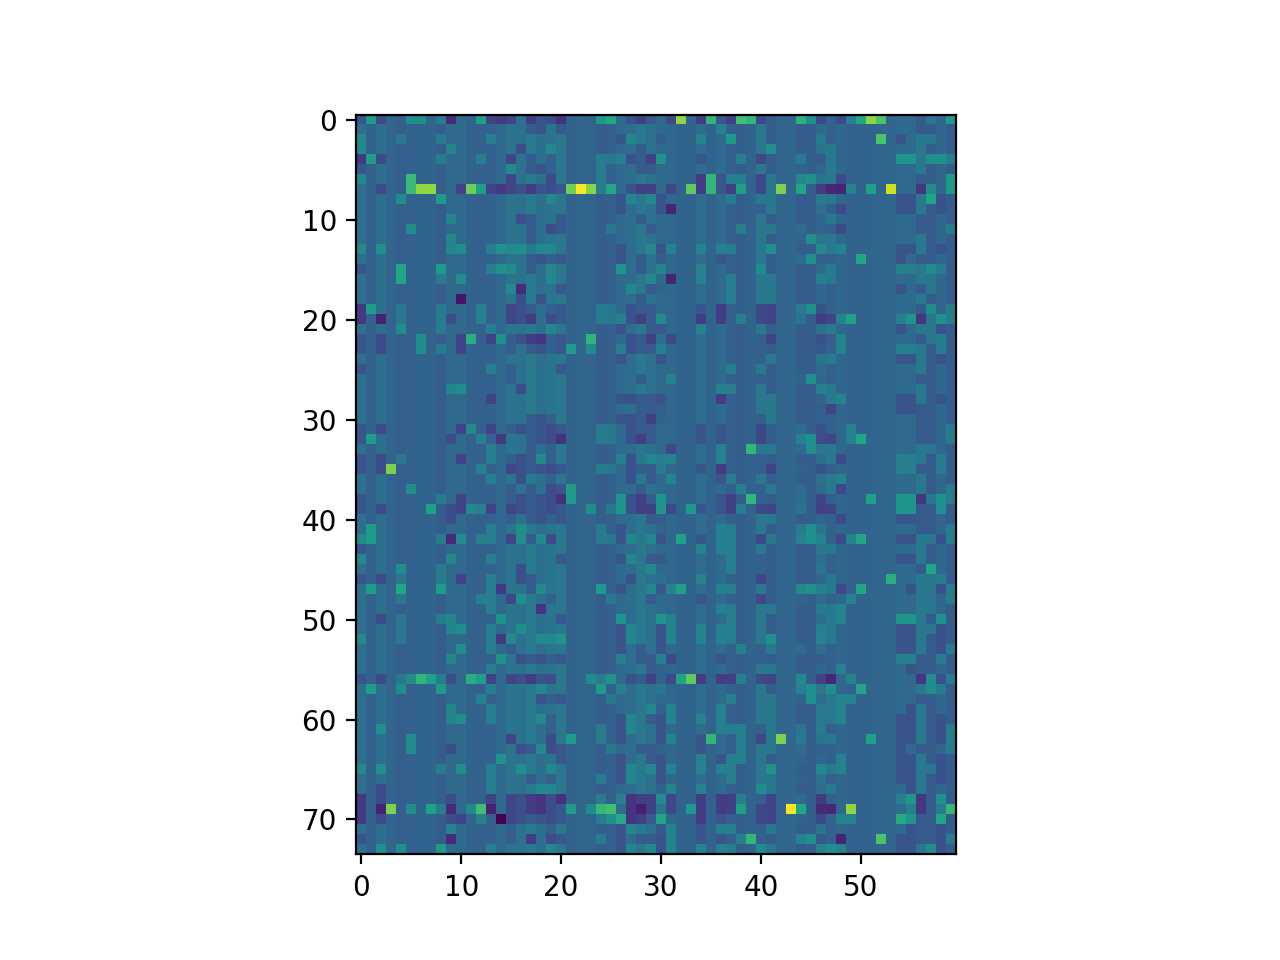

In [43]:
from scipy.stats import zscore
X3 = zscore(X2,axis=0)
print(X3.shape)
plt.close('all')
plt.imshow(X3)
plt.show()

## Singular Value Decomposition

In [52]:
U,S,Vh = np.linalg.svd(X3,full_matrices=False)
V = Vh.T
print(U.shape)
print(S.shape)
print(Vh.shape)

(74, 60)
(60,)
(60, 60)


<IPython.core.display.Javascript object>


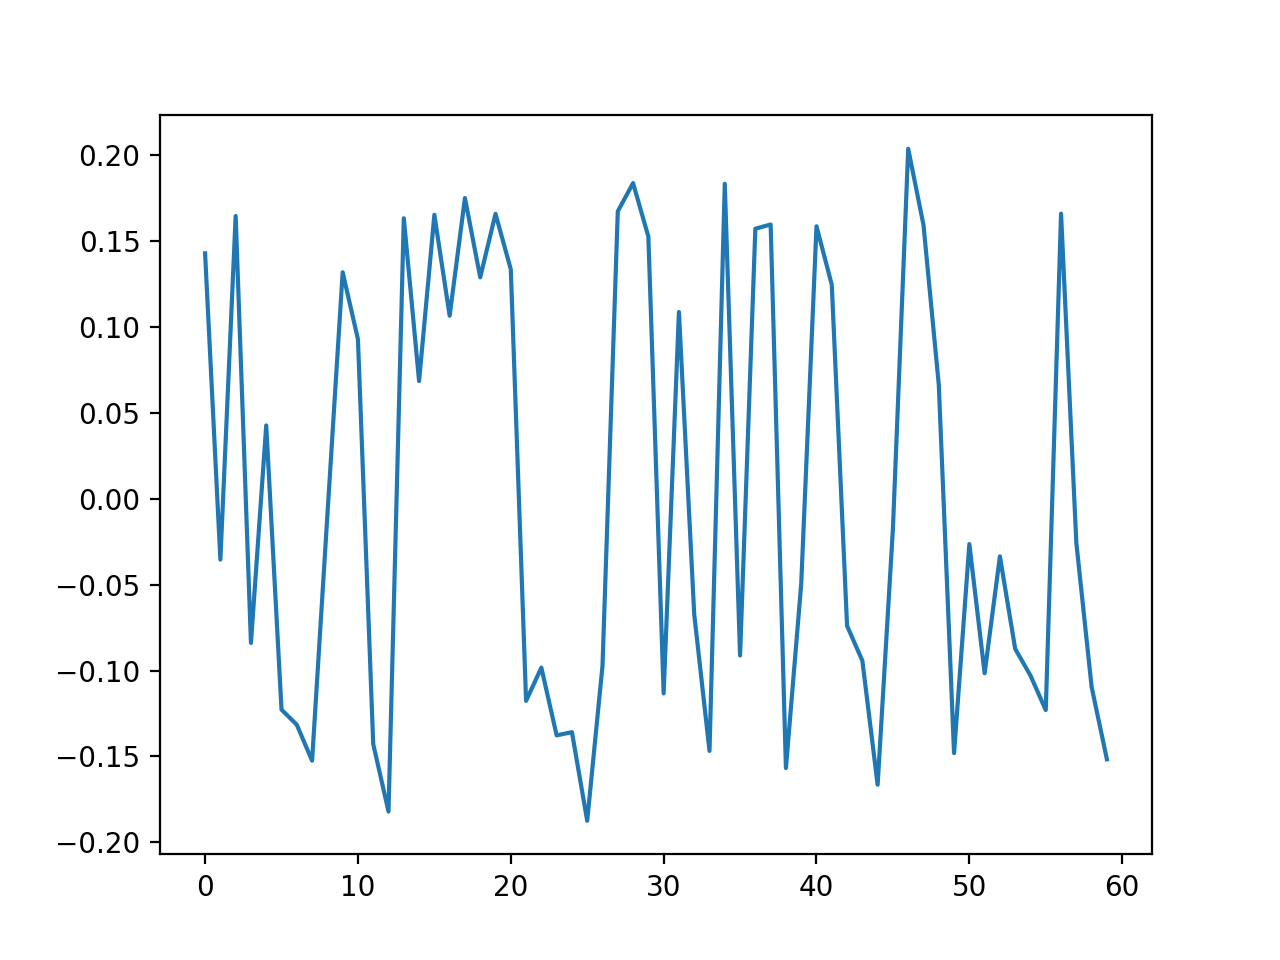

In [61]:
plt.close('all')
plt.plot(V[:,0])
plt.show()